#  Variational Inference

In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

import seaborn as sns

from swag import data, models, utils, losses
from swag.posteriors import SWAG

import tqdm

import os
import math

torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

import hamiltorch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
def featurize(x):
    return torch.cat([x[:, None], x[:, None]**2], dim=1)

class RegNet(nn.Sequential):
    def __init__(self, dimensions, input_dim=1, output_dim=1, apply_var=True):
        super(RegNet, self).__init__()
        self.dimensions = [input_dim, *dimensions, output_dim]        
        for i in range(len(self.dimensions) - 1):
            self.add_module('linear%d' % i, torch.nn.Linear(self.dimensions[i], self.dimensions[i + 1]))
            if i < len(self.dimensions) - 2:
                self.add_module('relu%d' % i, torch.nn.ReLU())

        if output_dim == 2:
            self.add_module('var_split', SplitDim(correction=apply_var))

#     def forward(self, x):
#         return super().forward(x)

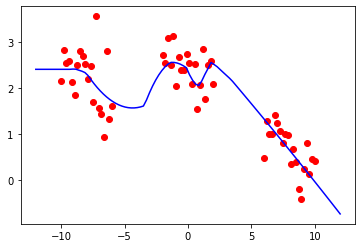

In [86]:
arr = np.load("data.npz") 
x = torch.from_numpy(arr['x'])
f = featurize(x)
y = torch.from_numpy(arr['y']) * 10

x_ = torch.from_numpy(arr['x_'])
f_ = featurize(x_)
y_ = torch.from_numpy(arr['y_']) * 10

plt.plot(x.data.numpy(), y.data.numpy(), "ro")
plt.plot(x_.data.numpy(), y_.data.numpy(), "-b")

In [51]:
n_steps = 3000

net = RegNet(dimensions=[10, 10, 10], input_dim=2)
optimizer = torch.optim.SGD(net.parameters(), lr=5e-6)
criterion = torch.nn.functional.mse_loss
noise_var = 0.0005
prior_var = 100

for epoch in range(n_steps):
    optimizer.zero_grad()
    preds = net(f)
    loss = criterion(preds, y) / (2 * noise_var)
    loss.backward()
    optimizer.step()

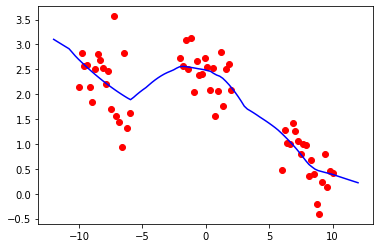

In [109]:
plt.plot(x.data.numpy(), y.data.numpy(), "ro")
plt.plot(x_.data.numpy(), net(f_).data.numpy(), "-b")

In [110]:
from swag.posteriors.ffg_vi_model import VIFFGModel
from swag.posteriors.vi_model import ELBO

In [111]:
init_sigma = .01
prior_var = 100
noise_var = 0.0005
criterion = losses.GaussianLikelihood(noise_var=noise_var)

vi_model = VIFFGModel(
    init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
    prior_log_sigma=math.log(np.sqrt(prior_var)),
    base=RegNet,
    dimensions=[10, 10, 10], input_dim=2
)

elbo = ELBO(criterion, len(y))
optimizer = torch.optim.Adam(vi_model.parameters(), lr=1e-6)

vi_model.mu.data = torch.cat([p.data.reshape(-1) for p in net.parameters()])

In [112]:
#     train_res = utils.train_epoch(loader, vi_model, elbo, optimizer, regression=True, cuda=False)
#     sigma = torch.nn.functional.softplus(vi_model.inv_softplus_sigma.detach().cpu())

n_steps = 10000

for epoch in range(n_steps):
    optimizer.zero_grad()
    loss = elbo(vi_model, f, y)[0]
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(epoch, loss)
    if epoch == 5000:
        utils.adjust_learning_rate(optimizer, 1e-8)



0 tensor(263.2856, grad_fn=<AddBackward0>)
100 tensor(246.7050, grad_fn=<AddBackward0>)
200 tensor(233.9647, grad_fn=<AddBackward0>)
300 tensor(283.3163, grad_fn=<AddBackward0>)
400 tensor(230.0835, grad_fn=<AddBackward0>)
500 tensor(230.9272, grad_fn=<AddBackward0>)
600 tensor(227.8602, grad_fn=<AddBackward0>)
700 tensor(233.2167, grad_fn=<AddBackward0>)
800 tensor(234.0340, grad_fn=<AddBackward0>)
900 tensor(235.4178, grad_fn=<AddBackward0>)
1000 tensor(262.3733, grad_fn=<AddBackward0>)
1100 tensor(235.5795, grad_fn=<AddBackward0>)
1200 tensor(236.4392, grad_fn=<AddBackward0>)
1300 tensor(273.7194, grad_fn=<AddBackward0>)
1400 tensor(305.7097, grad_fn=<AddBackward0>)
1500 tensor(240.2477, grad_fn=<AddBackward0>)
1600 tensor(253.6443, grad_fn=<AddBackward0>)
1700 tensor(263.3564, grad_fn=<AddBackward0>)
1800 tensor(239.5156, grad_fn=<AddBackward0>)
1900 tensor(234.6884, grad_fn=<AddBackward0>)
2000 tensor(300.3623, grad_fn=<AddBackward0>)
2100 tensor(248.0540, grad_fn=<AddBackward0>)


In [113]:
all_preds = np.vstack([vi_model(f_)[None, :].data.numpy() for _ in range(100)])

(-1, 4)

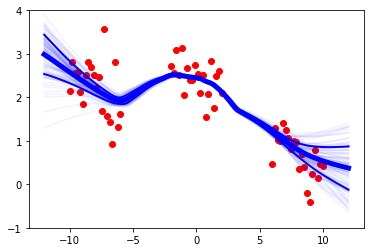

In [114]:
# all_preds = np.vstack([np.load("preds_de_{}.npy".format(i)) for i in range(n_ens)])
# all_preds = np.load("deep_ensembles_preds.npy")[:]
pred_mean = all_preds.mean(axis=0)
pred_std = all_preds.std(axis=0)
pred_upper = pred_mean + pred_std
pred_lower = pred_mean - pred_std

plt.plot(x.data.numpy(), y.data.numpy(), "ro")
# plt.plot(x_.data.numpy(), y_.data.numpy(), "--k")
plt.plot(x_.data.numpy(), all_preds[:, :, 0].T, "-b", alpha=0.05);
plt.plot(x_.data.numpy(), pred_mean, "-b", lw=5)
plt.plot(x_.data.numpy(), pred_lower, "-b", lw=2)
plt.plot(x_.data.numpy(), pred_upper, "-b", lw=2)
plt.ylim(-1, 4)

In [115]:
np.save("vi_preds", all_preds)